In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score

# 1.데이터 로드


In [ ]:
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_Labeled_50.csv')

In [ ]:
# df_org 복사 => df
df = df_org.copy()

In [ ]:
# df.head(3)
print('기지국 기기 개수 : {}개'.format(df.machine_id.nunique()))

기지국 기기 개수 : 51개


In [ ]:
# 수치형 변수 목록
target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

In [ ]:
# df[df[target_columns] < 0].isna().sum()

# 2.누락 데이터 보간

In [ ]:
# 전체 데이터 shape
df.shape

(61633, 16)

In [ ]:
# 시간 변수 생성
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [ ]:
df.head(2)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
0,MA1074_4_20210901_0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,7.873696,11.028859,27753.51401,0,2021-09-01 00:00:00
1,MA1074_4_20210901_1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,6.947635,10.664447,19952.83154,0,2021-09-01 01:00:00


## 2.1 시간 기준 키값 생성
- 누락된 시간대를 생성하기 위해, 원본 데이터와 join할 수 있는 고유키 역할의 기준 컬럼(기지국, 시간) 생성

In [ ]:
start_date = df['time'].min() # 시작날짜
end_date = df['time'].max() # 끝날짜
print('시작 날짜 : {}'.format(start_date))
print('종료 날짜 : {}'.format(end_date))
time_index = pd.date_range(start_date, end_date, freq='H')
print('전체 시간 인덱스 : {}개 \n{}'.format(len(time_index), time_index))

시작 날짜 : 2021-09-01 00:00:00
종료 날짜 : 2021-10-31 23:00:00
전체 시간 인덱스 : 1464개 
DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2021-10-31 14:00:00', '2021-10-31 15:00:00',
               '2021-10-31 16:00:00', '2021-10-31 17:00:00',
               '2021-10-31 18:00:00', '2021-10-31 19:00:00',
               '2021-10-31 20:00:00', '2021-10-31 21:00:00',
               '2021-10-31 22:00:00', '2021-10-31 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')


## 2.2 중복 행 삭제
- 원본 데이터 중 일부 중복 행(16쌍)이 발견되어 해당 행 모두 삭제
    - 2021년 9월 16일 16시 특정 시간대에 몇몇 기지국에 대해서 동일 데이터가 수집되었음
    - 중복된 행은 `tot_et`컬럼을 제외하고 모두 같은 값을 가지고 있음
    - `tot_et`변수의 range를 고려했을 때, 중복된 행 중 한 개만 골라 삭제할 수 있으나, 전체 6만개 행 중 *26개* 행은 대세에 영향이 없기 때문에 전체 삭제하는 방향으로 결정

In [ ]:
# 중복 행 확인
duplicated_row = df[df.duplicated(subset=['machine_id','time'], keep=False)]

print('중복된 행 개수(쌍): {}개'.format(duplicated_row.shape[0]))
duplicated_row.head(4)

중복된 행 개수(쌍): 26개


,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
351,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,322.14424,0,2021-09-16 16:00:00
352,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,37774.06968,0,2021-09-16 16:00:00
8887,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,313.88000,0,2021-09-16 16:00:00
8888,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,68408.51000,1,2021-09-16 16:00:00


In [ ]:
print("중복 제거 전 데이터 shape : {}".format(df.shape))
df = df.drop_duplicates(['machine_id', 'time'], keep=False)
print("중복 제거 후 데이터 shape : {}".format(df.shape))

중복 제거 전 데이터 shape : (61633, 17)
중복 제거 후 데이터 shape : (61607, 17)


## 2.3 df와 df_new 조인
- `machine_id`와 `time` 2개 컬럼에 대해 온전한 기준 데이터프레임(`df_new`) 생성
- 이후 원본 데이터(df)와 조인하여 누락된 시간대 복원

In [ ]:
# 기준 컬럼(df_new) 생성
df_new = pd.DataFrame()
machine_list = df.machine_id.unique()
for machine in machine_list:
    tmp = pd.DataFrame({
        'machine_id':[machine]*len(time_index),
        'time':time_index})
    df_new = pd.concat([df_new, tmp], axis=0)

In [ ]:
print("df_new 크기 : {}".format(df_new.shape))
df_new

df_new 크기 : (74664, 2)


,machine_id,time
0,MA1074_4,2021-09-01 00:00:00
1,MA1074_4,2021-09-01 01:00:00
2,MA1074_4,2021-09-01 02:00:00
3,MA1074_4,2021-09-01 03:00:00
4,MA1074_4,2021-09-01 04:00:00
...,...,...
1459,MA2561_18,2021-10-31 19:00:00
1460,MA2561_18,2021-10-31 20:00:00
1461,MA2561_18,2021-10-31 21:00:00
1462,MA2561_18,2021-10-31 22:00:00


In [ ]:
# df_new와 df 조인 (키 값=['machine_id', 'time'])
df_new = df_new.merge(df, on=['machine_id', 'time'], how='left')

In [ ]:
df_new.sample(3)

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
64472,MA2443_4,2021-09-03 08:00:00,MA2443_4_20210903_8,20210903.0,8.0,9.123333,21.0,99.23810,99.78118,100.0,18.860160,11.812280,102.96510,13.795110,17.339470,15541.490,0.0
61781,MA2239_3,2021-09-13 05:00:00,MA2239_3_20210913_5,20210913.0,5.0,2.890000,7.0,100.00000,100.00000,NaN,3.328976,0.747966,99.62025,5.770561,4.633901,9668.646,0.0
33702,MA1584_1,2021-09-02 06:00:00,MA1584_1_20210902_6,20210902.0,6.0,17.410230,34.0,99.87654,100.00000,100.0,15.934960,9.940014,103.78530,7.978830,17.761300,29298.730,0.0


## 2.4 y값 imputation
- 새로 채워진 시간대에 대한 y값은 `0` 레이블로 대체
 - <font color=yellow>해당 시간대에 대한 이상 판단 여부가 불확실하기 때문에 임의의 값으로 채우는 것보다 0으로 채우는 것이 안전하다고 판단</font>

In [ ]:
# 누락된 y레이블은 0으로 대체
df_new['y'] = df_new['y'].fillna(0)

In [ ]:
df_new.iloc[[3],:]

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# machine_list = df_new['machine_id'].unique()
# df_new['year'] = df_new['time'].dt.year # 년
# df_new['month'] = df_new['time'].dt.month # 월

# for idx, machine in enumerate(machine_list):
#     print(df_new.loc[df_new['machine_id'] == machine].groupby(['year', 'month']).size())

# 3.데이터 전처리
- 전체 51개의 기지국 기기 중 랜덤하게 10개 샘플링하여 테스트 진행

## 3.1 샘플링

In [ ]:
# 랜덤하게 10개 기기 선택
random_machine = list(np.random.choice(df_new.machine_id.unique(),2, replace=False))

In [ ]:
print(random_machine)

['MA1704_7', 'MA1313_1']


In [ ]:
# 10개 기기에 대한 데이터만 샘플링
df_test = df_new.loc[df_new['machine_id'].apply(lambda x: x in random_machine), :].reset_index(drop=True)

In [ ]:
# 샘플링 결과 검증
df_test.shape, 10 * 61 * 24

((2928, 17), 14640)

In [ ]:
df_test.head()

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
0,MA1313_1,2021-09-01 00:00:00,MA1313_1_20210901_0,20210901.0,0.0,20.46415,37.0,70.39106,100.0,100.0,22.01908,78.34559,101.2994,9.875808,32.38360,37836.21,0.0
1,MA1313_1,2021-09-01 01:00:00,MA1313_1_20210901_1,20210901.0,1.0,57.09778,90.0,45.83333,100.0,100.0,28.49868,93.04550,100.1200,12.846010,36.07570,89603.18,0.0
2,MA1313_1,2021-09-01 02:00:00,MA1313_1_20210901_2,20210901.0,2.0,54.16889,77.0,40.61433,100.0,100.0,24.32589,93.73137,100.1471,10.941110,34.28094,88013.65,0.0
3,MA1313_1,2021-09-01 03:00:00,MA1313_1_20210901_3,20210901.0,3.0,50.16176,84.0,5.98338,100.0,100.0,17.01074,93.76043,100.3162,8.682980,35.13840,104390.80,0.0
4,MA1313_1,2021-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


- 보간 시 음수로 채워진 값들은 0으로 변환
- 아래 그림과 같이 대부분의 변수에서 음수는 유효하지 않음
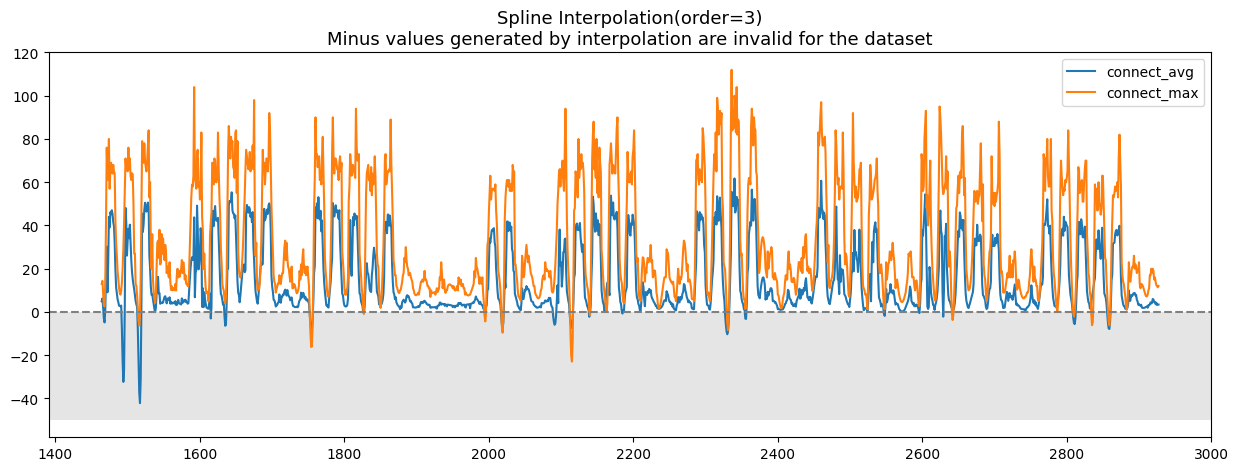

## 3.2 보간/로그차분/파생변수

In [ ]:
%%time
import holidays
from datetime import date

def preprocessing(df):
    # 보간&차분 적용 대상 컬럼 선정
    target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']
    # 기지국 고유 id 리스트
    machine_list = df['machine_id'].unique()

    for idx, machine in enumerate(machine_list):
        # spline3로 결측치 보간 후 bfill로 나머지 결측치 채우기
        tmp = df.loc[df['machine_id'] == machine, target_columns].interpolate(method='spline', order=3).bfill()
        tmp[tmp < 0] = 0 # 음수값으로 보간된 수치에 대해서는 0으로 변환
        tmp = np.log1p(tmp).diff(periods=24, axis=0) # 로그 차분 24시간 적용, 0값 고려 log1p 적용
        df.loc[df['machine_id'] == machine, target_columns] = tmp # 변경된 값으로

    df = df.dropna(axis=0, subset=target_columns).reset_index(drop=True) # 로그 차분 결과 발생한 nan 행 제거

    # 시간 파생변수 생성
    df['year'] = df['time'].dt.year # 년
    df['month'] = df['time'].dt.month # 월
    df['day'] = df['time'].dt.day # 일
    df['hour'] = df['time'].dt.hour # 시간
    df['dayofweek'] = df['time'].dt.dayofweek # 요일
    df['is_weekend'] = df['dayofweek'].apply(lambda x : 1 if x >= 5 else 0) # 주중/주말
    df['is_night'] = df['hour'].apply(lambda x : 1 if x >= 23 or x <= 7 else 0) # 주간/야간
    df['is_commute'] = df['hour'].apply(lambda x : 1 if (x >= 7 and x <= 9) or (x >= 17 and x <= 19) else 0)

    # cyclical encoding
    df['day_sin'] = np.sin(df['day'] / 31 * 2 * np.pi)
    df['day_cos'] = np.cos(df['day'] / 31 * 2 * np.pi)

    df['dayofweek_sin'] = np.sin(df['dayofweek'] / 7 * 2 * np.pi)
    df['dayofweek_cos'] = np.cos(df['dayofweek'] / 7 * 2 * np.pi)

    df['hour_sin'] = np.sin(df['hour'] / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['hour'] / 24 * 2 * np.pi)

    # 휴일 컬럼
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['time'].apply(lambda x : 1 if x in kr_holidays else 0)

    # 기지국 파생변수 생성
    df['station'] = df['machine_id'].apply(lambda x : x.split('_')[0])
    return df

df_try = df_new.copy() # 원본 수정 없이 반복적으로 테스트 시행을 위해 df_try에 copy
df_processed = preprocessing(df_try)
df_processed

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

CPU times: user 1min 7s, sys: 135 ms, total: 1min 7s
Wall time: 1min 20s


,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,...,is_night,is_commute,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,is_holiday,station
0,MA1074_4,2021-09-02 00:00:00,MA1074_4_20210902_0,20210902.0,0,-0.016140,0.058841,-0.003187,0.000000,0.000000,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.000000,1.000000,0,MA1074
1,MA1074_4,2021-09-02 01:00:00,MA1074_4_20210902_1,20210902.0,1,-0.040375,-0.039221,-0.381298,0.004795,0.006286,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.258819,0.965926,0,MA1074
2,MA1074_4,2021-09-02 02:00:00,NaN,NaN,2,0.060340,-0.163080,-0.067532,0.005599,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.500000,0.866025,0,MA1074
3,MA1074_4,2021-09-02 03:00:00,MA1074_4_20210902_3,20210902.0,3,0.226949,-0.007034,0.003485,-0.000007,0.001350,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.707107,0.707107,0,MA1074
4,MA1074_4,2021-09-02 04:00:00,NaN,NaN,4,0.175298,0.090093,-0.077281,-0.000262,-0.001361,...,1,0,3.943559e-01,0.918958,0.433884,-0.900969,0.866025,0.500000,0,MA1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73435,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19,-0.126192,-0.147636,-0.001250,0.006266,0.000000,...,0,1,-2.449294e-16,1.000000,-0.781831,0.623490,-0.965926,0.258819,0,MA2561
73436,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20,-0.093788,0.133531,0.003230,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.866025,0.500000,0,MA2561
73437,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21,0.408807,0.241162,0.004017,0.000000,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.707107,0.707107,0,MA2561
73438,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22,0.177838,0.168623,0.003581,-0.004771,0.000000,...,0,0,-2.449294e-16,1.000000,-0.781831,0.623490,-0.500000,0.866025,0,MA2561


In [ ]:
# df_processed[['connect_avg', 'connect_max']].plot(kind='line', figsize=(15,5))
# plt.title('Spline Interpolation(order=3)\nMinus values generated by interpolation are invalid for the dataset', fontsize=13)
# plt.axhline(0, linestyle='--', color='grey')
# ax = plt.gca()
# ymin, ymax = ax.get_ylim()
# plt.axhspan(ymin, 0, facecolor='grey', alpha=0.2)
# plt.show()

In [ ]:
df.y.value_counts()/df.shape[0],\
df_processed.y.value_counts()/df_processed.shape[0]

(0    0.850439
 1    0.149561
 Name: y, dtype: float64,
 0.0    0.876974
 1.0    0.123026
 Name: y, dtype: float64)

## 3.3 분리/스케일링/인코딩

In [ ]:
def split_scaling_encoding(df, preprocessing=False, to_automl=False):
    X = df.drop(['ckey', 'date', 'time', 'y'], axis=1)
    y = df['y']

    categorical_columns = ['station', 'machine_id', 'year', 'month']
    numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']


    preprocessor = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (OneHotEncoder(sparse_output=False), categorical_columns),
    )

    if not to_automl: # to_automl이 False인 경우 분리, 스케일링, 인코딩 처리
        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        if not preprocessing:
            return X_train, X_test, y_train, y_test
        else:
            X_train_processed = preprocessor.fit_transform(X_train)
            X_test_processed = preprocessor.transform(X_test)
            return X_train_processed, X_test_processed, y_train, y_test

    else: # to_automl이 True인 경우 X, y만 분리 후 return
        return X, y

# X_train_p, X_test_p, y_train, y_test = split_scaling_encoding(df_new, to_automl=True)

X, y = split_scaling_encoding(df_processed, preprocessing=False, to_automl=True)

In [ ]:
X.shape, y.shape

((73440, 28), (73440,))

# 4.AutoML

In [ ]:
# !pip install -q --pre pycaret
!pip install -q pycaret[models]

In [ ]:
!pip install -q catboost

## 4.1 환경설정

In [ ]:
from pycaret.utils import version
from catboost import CatBoostClassifier
version()

'3.2.0'

In [ ]:
from pycaret.classification import *

In [ ]:
len(X.columns)

28

In [ ]:
categorical_features = ['station', 'machine_id', 'year', 'month']

numerical_features = ['connect_avg', 'connect_max', 'in_handover_rate',
                    'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb',
                    'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

passthrough = ['is_weekend', 'is_night', 'is_commute', 'is_holiday', 'day_sin',
               'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos']

ignore_features = ['day', 'dayofweek', 'hour']

## 4.2 모델 비교(SMOTE적용)

In [ ]:
smote_s = setup(data=X, target=y,
          session_id=124,
          train_size=0.8, fold=5, verbose=True,
          ordinal_features=None,
          categorical_features=categorical_features,
          numeric_features=numerical_features,
          keep_features = passthrough,
          normalize=True,
          normalize_method='zscore',
          fold_strategy='stratifiedkfold',
          fold_shuffle=True,
          fix_imbalance=True)

,Description,Value
0,Session id,124
1,Target,y
2,Target type,Binary
3,Original data shape,"(73440, 29)"
4,Transformed data shape,"(117736, 29)"
5,Transformed train set shape,"(103048, 29)"
6,Transformed test set shape,"(14688, 29)"
7,Ordinal features,1
8,Numeric features,11
9,Categorical features,4


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### custom metric 추가
- F1 score : Recall = Precision
- F2 score : Recall > Precision
- F0.5 score : Recall < Precision

In [ ]:
# custom metric 정의
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# custom metric 추가
add_metric('f2', 'F2', f2_score, target='pred')

Name                                                                F2
Display Name                                                        F2
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                           make_scorer(f2_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: f2, dtype: object

In [ ]:
def f0_5_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)

add_metric('f0_5', 'F0.5', f0_5_score, target='pred')

Name                                                              F0.5
Display Name                                                      F0.5
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                         make_scorer(f0_5_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: f0_5, dtype: object

In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7edf1c70b6d0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7edf1c70b7f0>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7edf1c70b910>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f2,F2,F2,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f2_score),pred,{},True,True,True
f0_5,F0.5,F0.5,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f0_5_score),pred,{},True,True,True


In [ ]:
# remove_metric('f2')
# remove_metric('f0_5')

In [ ]:
best = compare_models(n_select=5, sort='F2') # 19분 00초 소요

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,F0.5,TT (Sec)
gbc,Gradient Boosting Classifier,0.8371,0.9028,0.7749,0.4135,0.5392,0.4511,0.4841,0.6595,0.4560,57.0280
ada,Ada Boost Classifier,0.8186,0.8928,0.7980,0.3856,0.5199,0.4244,0.4671,0.6573,0.4300,12.8060
lr,Logistic Regression,0.8043,0.8834,0.8070,0.3661,0.5037,0.4025,0.4514,0.6503,0.4110,4.5240
svm,SVM - Linear Kernel,0.7963,0.0000,0.8145,0.3566,0.4959,0.3918,0.4445,0.6478,0.4017,1.8120
ridge,Ridge Classifier,0.7936,0.0000,0.8103,0.3526,0.4913,0.3861,0.4388,0.6433,0.3975,0.9260
lda,Linear Discriminant Analysis,0.7936,0.8743,0.8102,0.3525,0.4913,0.3860,0.4387,0.6432,0.3974,1.3160
knn,K Neighbors Classifier,0.8052,0.8469,0.7620,0.3616,0.4905,0.3884,0.4297,0.6238,0.4041,23.5340
rf,Random Forest Classifier,0.8865,0.9146,0.6404,0.5322,0.5812,0.5162,0.5193,0.6153,0.5508,35.0060
et,Extra Trees Classifier,0.8816,0.9052,0.6079,0.5159,0.5581,0.4902,0.4925,0.5869,0.5320,13.5080
xgboost,Extreme Gradient Boosting,0.8948,0.9133,0.5607,0.5745,0.5674,0.5076,0.5077,0.5634,0.5716,3.4960


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

In [ ]:
print("현재 seed : {}".format(get_config('seed')))

현재 seed : 124


In [ ]:
best

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=124, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                    estimator=None, learning_rate=1.0, n_estimators=50,
                    random_state=124),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto'

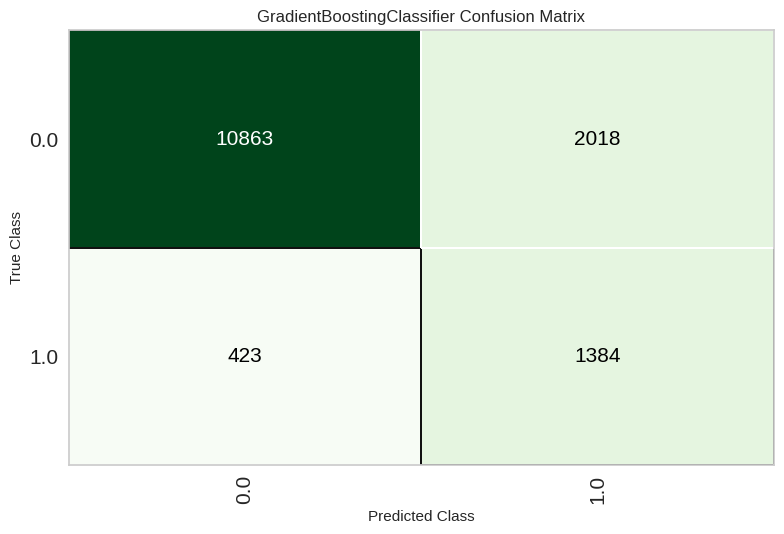

In [ ]:
plot_model(best[0], plot = 'confusion_matrix')

In [ ]:
# # functional API
# predict_model(best)